# Fitting Distributions 

In [1]:
#libraries

import pandas as pd
import datetime
import psycopg2
import numpy as np
import os
import seaborn as sns
pd.set_option("display.max_columns",999)
import seaborn as sns
from fitter import Fitter, get_common_distributions, get_distributions

import warnings
warnings.filterwarnings('ignore')

pd.options.display.float_format = '{:.2f}'.format
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

In [2]:
# paths

LOCAL = os.environ['LOCAL_REPOSITORY_LOCATION']
folder_dist = 'DAPT\cost\distributions'
path_dist = os.path.join(LOCAL, folder_dist)
fn = 'lease_clean_oct29.csv'

In [3]:
# read in data from RDS

def read_data():
    # reads in Oct 29 rds lease data
    
    conn = psycopg2.connect(
        host = 'lease-data.cnzawwknyviz.us-east-1.rds.amazonaws.com',
        port = 5432,
        user = 'costar',
        password = 'Costar12',
        database='costar'
        )
    cursor = conn.cursor() 

    try:
        df = pd.read_csv('downtime_lease_nov8.csv')
        
    except:
        q = '''
            SELECT
                *
            FROM downtime_lease_nov8
            '''
        df = pd.read_sql(q, 
                         con = conn)

    return df

dfm = read_data()

dfm.shape

(557607, 29)

In [4]:
# resources
'''
https://towardsdatascience.com/finding-the-best-
distribution-that-fits-your-data-using-pythons-
fitter-library-319a5a0972e9
'''

'\nhttps://towardsdatascience.com/finding-the-best-\ndistribution-that-fits-your-data-using-pythons-\nfitter-library-319a5a0972e9\n'

#### Functions

In [5]:
def desc_stat_col(column):
    '''quick function that produces 
        descriptive stats on a chosen column'''

    pcts = [.01, .05, .10, .25, .5, .75, .90, .95, .99]

    df = dfm[column]
    
    print('DESCRIPTIVE STATS WITHOUT MODIFICATIONS:')
    print('\r')
    print(df.describe(percentiles = pcts).T)

In [6]:
def make_hist(column, bins, lower_pct, upper_pct, color):
    '''Produces descr stats, 
        removes lower & upper bounds (if desired),
        produces histogram'''
    
    df = dfm
    
    min_down = df.days_on_market.min()
    
    range_min = df[column].quantile(lower_pct)
    range_max = df[column].quantile(upper_pct)
    
    print('\r')
    print('\r')
    print(f'HISTOGRAM WITH LOWER & UPPER BOUNDS REMOVED, lower: {lower_pct*100}%, upper: {upper_pct*100}%')
    df[column].hist(bins = bins, range = (range_min, range_max), color = color)

In [7]:
def make_violin(column, color):

    sns.set_theme(style="whitegrid")
    ax = sns.violinplot(data = dfm, x=dfm[column], color = color, width = 2)   
    
# make_violin('days_on_market', 'red')
# make_violin('new_days_on_market', 'green')

In [8]:
def create_tag_column(column, lower_pct, upper_pct):
    
    new_column = 'new_' + column
    min_range = dfm[column].quantile(lower_pct)
    max_range = dfm[column].quantile(upper_pct)

    dfm[new_column] = dfm[column][(dfm[column] >= min_range) & (dfm[column] <= max_range)]
    print('\r')
    print(f'NEW COLUMN CREATED WITH UPPER & LOWER BOUNDS: {dfm.columns[-1]}')

DESCRIPTIVE STATS WITHOUT MODIFICATIONS:

count   557607.00
mean        17.32
std         17.50
min          0.00
1%           0.00
5%           0.00
10%          3.00
25%          6.00
50%         12.00
75%         24.00
90%         42.00
95%         57.00
99%         78.00
max         84.00
Name: vacant_months, dtype: float64


HISTOGRAM WITH LOWER & UPPER BOUNDS REMOVED, lower: 0%, upper: 95.0%

NEW COLUMN CREATED WITH UPPER & LOWER BOUNDS: new_vacant_months


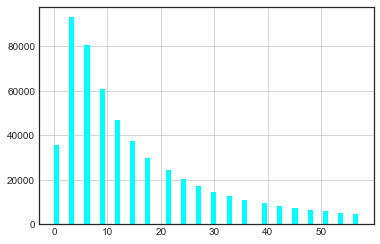

In [9]:
'''DOWNTIME: 
    Rows above 95 percentile were eliminated
    for downtime per Rob's instruction; landlords
    often have buildings off market for major rennovations.'''

# parameters: column
desc_stat_col('vacant_months')

# parameters: column, bins, lower_pct, upper_pct, color
make_hist('vacant_months', 60, 0, .95, 'aqua')

# parameters: column, lower, upper 
create_tag_column('vacant_months', 0, .997)

# USE DOWNTIME W/O REMOVING OUTLIERS

In [54]:
# import fitter
# f = fitter.Fitter(dt)

# # just a trick to use only 10 distributions instead of 80 to speed up the fitting
# f.distributions = f.distributions[0:10] + ['lognorm']

# # fit and plot
# f.fit()
# f.summary()

### Downtime Geographical Heirarchy

In [10]:
df = dfm

In [11]:
df.shape

(557607, 30)

In [12]:
#strip whitespace
df.cbsa_state_new = df.cbsa_state_new.str.strip()

#replace '-' w/ '_'
df.cbsa_state_new = df.cbsa_state_new.replace('-', '_')

In [20]:
list(get_common_distributions())

['cauchy',
 'chi2',
 'expon',
 'exponpow',
 'gamma',
 'lognorm',
 'norm',
 'powerlaw',
 'rayleigh',
 'uniform']

In [25]:
# # https://stackoverflow.com/questions/30215677/how-to-create-a-data-frame-for-each-group-in-the-pandas-groupby-function
# grouped = df.groupby('cbsa_state_new')

# d = {}

# for name, group in grouped:
#     d[str(name)] = group
        
# d['PA']

,leasedeal_id,property_id,lease_term_in_months,rate_actual,estimated_rent,actual_esti_rent_ratio,service_type_id,property_type_id,location_occupancy_id,tenant_improvement_allowance_persqft,free_months,construction_year,building_rating_id,research_market_name,cbsaid,cbsa_cities,cbsa_states,cbsa_state_new,submarket_name,zip,sqft_min,sqft_max,date_on_market,date_off_market,days_on_market,actual_vacancy,year_on_market,year_off_market,vacant_months,new_vacant_months
10,111987242,7227230,84.00,22.50,20.91,1.08,7.00,5,116966594,NaN,NaN,2002.0,2,Philadelphia,37980.0,Philadelphia-Camden-Wilmington,PA-NJ-DE-MD,PA,Ft Wash/Spring House,19002.00,1685.00,1685.00,2009-09-30,2010-09-30,365.00,1.00,2009,2010,12.00,12.00
14,111433391,1385898,36.00,NaN,16.59,NaN,11.00,5,114304614,NaN,NaN,1968.0,2,Other Market Areas,35260.0,New Castle,PA,PA,New Castle,16101.00,2046.00,2046.00,2008-12-31,2009-03-31,90.00,0.00,2008,2009,3.00,3.00
19,122416181,5668507,11.00,NaN,22.48,NaN,9.00,5,139604721,NaN,NaN,1924.0,2,Philadelphia,37980.0,Philadelphia-Camden-Wilmington,PA-NJ-DE-MD,PA,Plymouth Mtg/Blue Bell,19428.00,1547.00,1547.00,2014-09-30,2015-09-30,365.00,0.00,2014,2015,12.00,12.00
51,112330656,578862,60.00,16.95,12.23,1.39,5.00,5,119214375,NaN,NaN,1986.0,3,Philadelphia,25420.0,Harrisburg-Carlisle,PA,PA,Harrisburg Area East,17109.00,1712.00,1712.00,2010-06-30,2011-06-30,365.00,0.00,2010,2011,12.00,12.00
74,113586418,69987,13.00,NaN,14.14,NaN,7.00,5,121722337,NaN,1.00,1940.0,2,Pittsburgh,38300.0,Pittsburgh,PA,PA,Parkway West Corridor,15106.00,805.00,805.00,2012-09-30,2013-03-31,182.00,1.00,2012,2013,6.00,6.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
557464,114448294,68660,60.00,NaN,18.25,NaN,7.00,5,123355385,NaN,NaN,1983.0,3,Pittsburgh,38300.0,Pittsburgh,PA,PA,Parkway East Corridor,15221.00,1112.00,1112.00,2009-12-31,2014-09-30,1734.00,1.00,2009,2014,57.00,57.00
557545,110969470,5947384,60.00,NaN,19.76,NaN,6.00,5,113301279,NaN,NaN,None,2,Other Market Areas,44300.0,State College,PA,PA,State College,16803.00,1825.00,1825.00,2007-09-30,2008-03-31,183.00,0.00,2007,2008,6.00,6.00
557547,157962781,5730002,24.00,NaN,13.83,NaN,13.00,5,242749101,NaN,NaN,1989.0,2,Pittsburgh,38300.0,Pittsburgh,PA,PA,Beaver County,15061.00,1360.00,1360.00,2015-06-30,2018-09-30,1188.00,0.00,2015,2018,39.00,39.00
557551,110796474,921583,24.00,NaN,15.10,NaN,7.00,5,112792107,NaN,1.00,1999.0,3,Pittsburgh,38300.0,Pittsburgh,PA,PA,Northeast Pittsburgh,15101.00,3000.00,3000.00,2005-06-30,2007-06-30,730.00,1.00,2005,2007,24.00,24.00


In [34]:
df.cbsa_state_new.unique()

array(['NY', 'TX', 'IA', 'WI', 'CA', 'MA', 'PA', 'RI', 'CO', 'NV', 'FL',
       'OH', 'MO', 'NE', 'CT', 'IL', 'SC', 'GA', 'MI', 'NC', 'MN', 'AZ',
       'DC', 'AL', 'OR', 'WA', 'UT', 'IN', 'NH', 'WV', 'TN', 'MD', 'MS',
       'VA', 'AR', 'NJ', 'KY', 'OK', 'KS', 'MT', 'ID', 'NM', 'ME', 'LA',
       'HI', 'SD', 'WY', 'ND', 'VT', 'AK', 'DE'], dtype=object)

In [55]:
grouped = df.groupby('cbsa_state_new')

s = ''

for i in df.cbsa_state_new.unique():
    i = grouped.get_group(str(i))

In [43]:
#distfit

NameError: name 'NY' is not defined

,sumsquare_error,aic,bic,kl_div
lognorm,0.11,1340.92,-8618781.47,inf


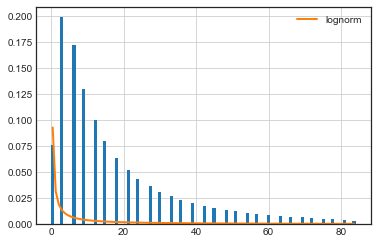

In [21]:
# get_distributions()

f = Fitter(dt,
           distributions = [
                            'lognorm',
#                             'beta',
#                             'gamma'
                           ])

f.fit()

f.summary()

In [19]:
d = f.get_best(method = 'aic')

dfd = pd.DataFrame(d)

dfd.T

,loc,s,scale
lognorm,-0.00,9.94,4.26
